# try to mitigate PSFs

attempt to use the fit_saturated_stars code from jw02731 development to fit stars and remove their PSFs

## Preamble: load things

In [2]:
import sys
sys.path.append('../reduction')
from saturated_star_finding import *

/blue/adamginsburg/adamginsburg/jwst/brick/notebooks/../reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [4]:
from astropy import coordinates

In [5]:
import numpy as np

In [6]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [7]:
import warnings

In [8]:
import regions

In [9]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [10]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [11]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100

In [12]:
import glob
from astropy.io import fits

In [13]:
ls ../F466N/pipeline/*-merge*fits

../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged-reproject_i2d_reprj_f410.fits
../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_segm.fits


In [14]:
from astropy.io import fits

## Load & inspect data

In [14]:
fh = fits.open('../F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-merged_i2d.fits')

In [15]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [16]:
np.any(bad)

True

In [17]:
data = fh['SCI'].data
data[bad] = 0

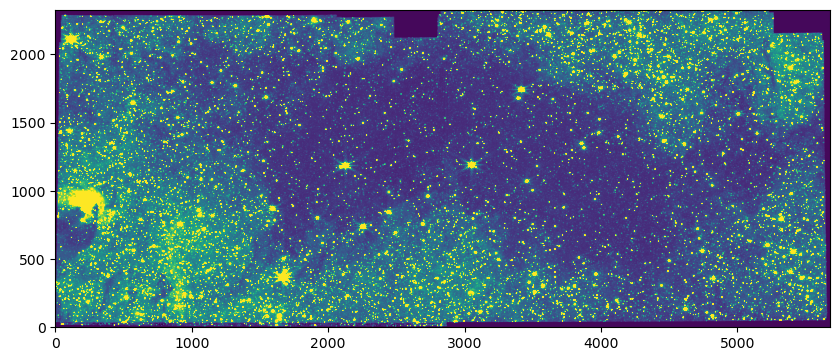

In [18]:
pl.imshow(data, vmin=-1, vmax=50, origin='lower')

54

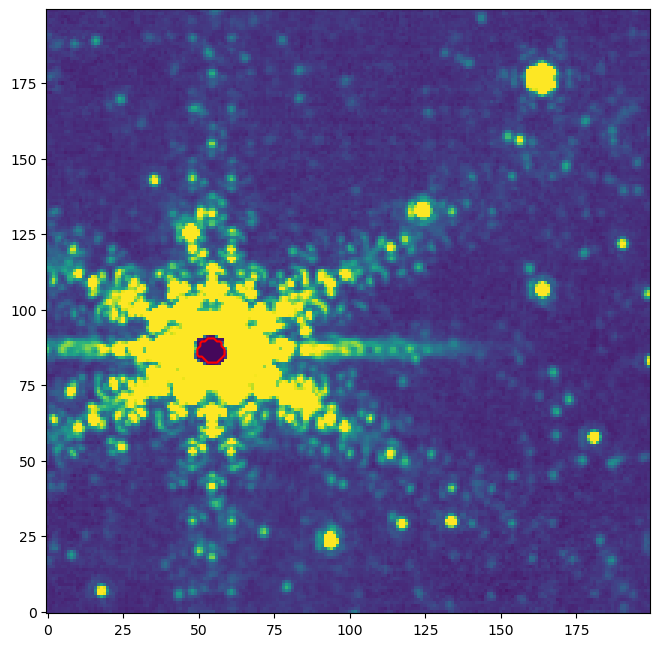

In [19]:
slc = slice(1100, 1300), slice(3000, 3200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

25

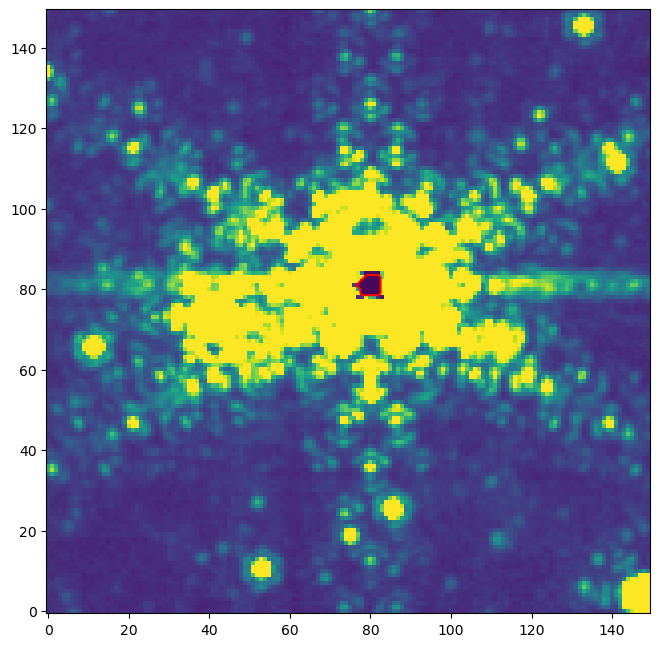

In [20]:
slc = slice(1100, 1250), slice(2050, 2200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

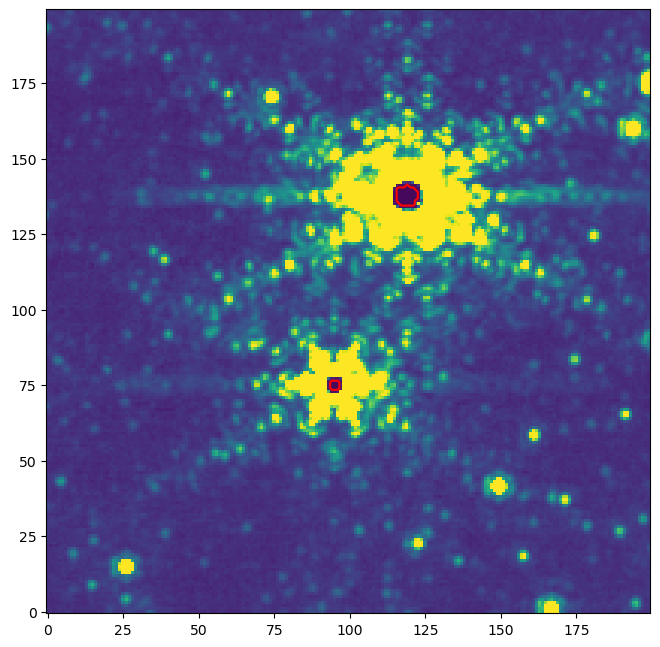

In [21]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 100) and min_flux=500, number of is_star=99, sizes=112, centerofmass_finite=112, coms_inbounds=112, total=99 candidates


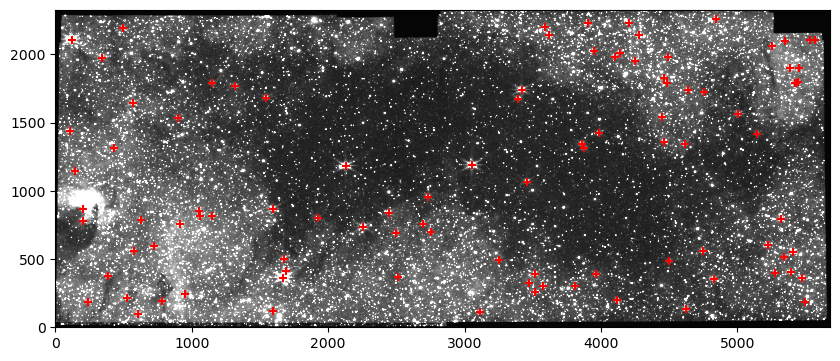

In [22]:
satstar_cat = finder_maker(min_sep_from_edge=50)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [23]:
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), fh[0].header)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: Loading grid from psf_fn=./nircam_F466N_samp2_nspsf16_npix512_nrcb5.fits [__main__]
Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with m

Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (50, 100) and min_flux=1000, number of is_star=3, sizes=3, centerofmass_finite=112, coms_inbounds=112, total=3 candidates
Reduced nsources from 472 to 112 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (50, 100) and min_flux=1000, number of is_star=3, sizes=3, centerofmass_finite=112, coms_inbounds=112, total=3 candidates
       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit          flux_unc            x_0_unc              y_0_unc       
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ----------------- ------------------ -------------------- --------------------
1672.3417721518988 363.34177215189874  920667.5621203217   1        1 1672.5159673157607 363.15801755282683 6939965.321650894 28737.703910665867

       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc              y_0_unc       
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- --------------------
             608.0               99.5   88035.9130972873   1        1  607.6485285327467    96.912733413182 23450.086431931017 1481.6608929430033  0.08717861699964051    0.103765824123464
            1596.5              116.5  84492.26228151203   2        2  1596.473748690144 116.50392970953244 115477.92080942464 3107.7607098276535  0.01833935016903461 0.018744046240698763
            5496.5              186.5   7510.27334252801   3        3  5496.469612513319 186.49885314430992  4985.258666717533 2204.9406595128958   0.2853853960506496   0.3131909687629681
            4117.5              196.5  74486.65156497613   4

In [24]:
satstar_table[:3]

<QTable length=3>
       x_0                y_0               flux_0         id  group_id       x_fit              y_fit             flux_fit          flux_unc            x_0_unc              y_0_unc       
     float64            float64            float64       int64  int64        float64            float64            float64           float64             float64              float64       
------------------ ------------------ ------------------ ----- -------- ------------------ ------------------ ----------------- ------------------ -------------------- --------------------
1672.3417721518988 363.34177215189874  920667.5621203217     1        1 1672.5159673157607 363.15801755282683 6939965.321650894 28737.703910665867 0.005626799793248592 0.006180539149700383
3054.0925925925926 1186.4259259259259 441115.18904128775     2        2  3054.575280444512 1186.5927474625155 3266605.373876641  9447.862326578594 0.003952746566626915  0.00420736747499905
120.01010101010101  2107.090909090909  664275.6873329213     3        3 119.51871714716864  2107.307109726284 5031288.301538509  30270.70795925081 0.008458055758859358 0.009109461867771078

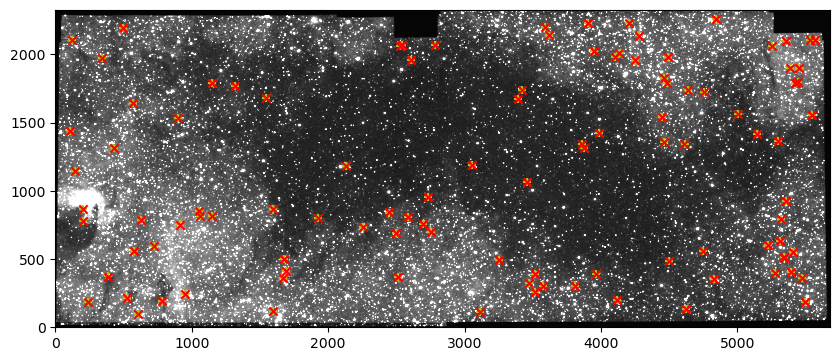

In [25]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')

(0.0, 200.0, 0.0, 200.0)

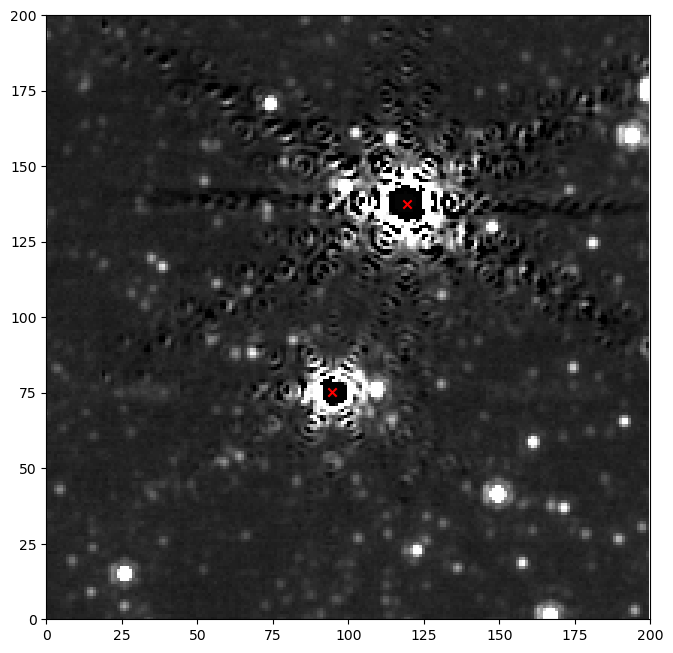

In [26]:
pl.imshow(satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

(0.0, 200.0, 0.0, 200.0)

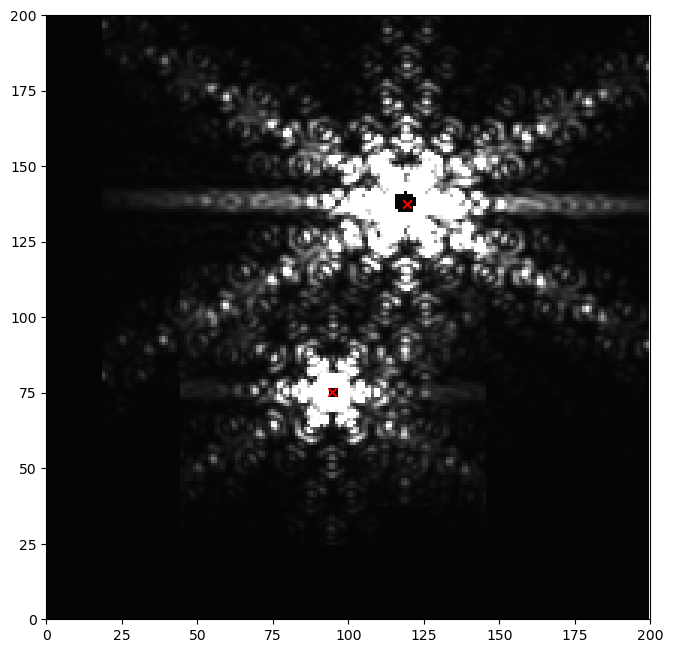

In [27]:
pl.imshow(data[1600:1800, 3300:3500] - satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

## Repeat for more difficult case: F410M

In [28]:
fh = fits.open('../F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-merged_i2d.fits')

In [29]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [30]:
np.any(bad)

True

In [31]:
data = fh['SCI'].data
data[bad] = 0

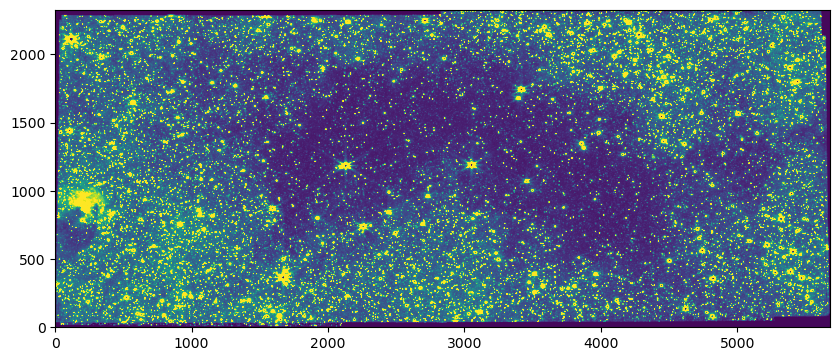

In [32]:
pl.imshow(data, vmin=-1, vmax=50, origin='lower')

325

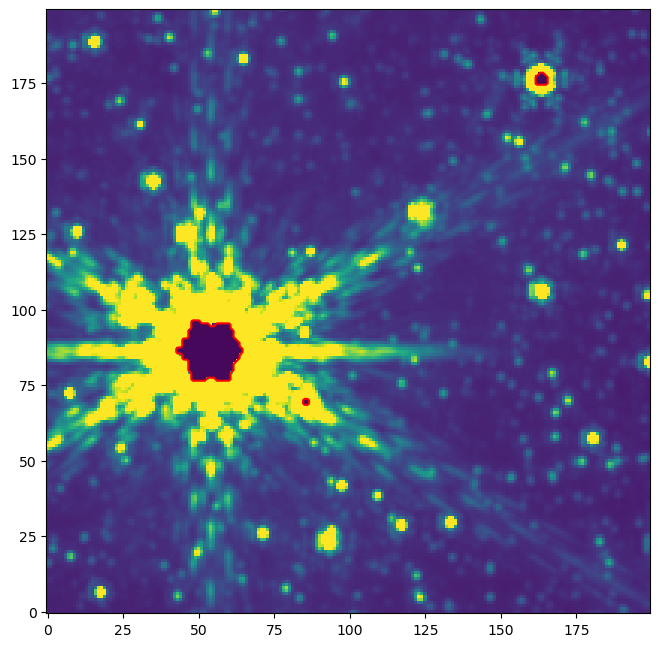

In [33]:
slc = slice(1100, 1300), slice(3000, 3200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

331

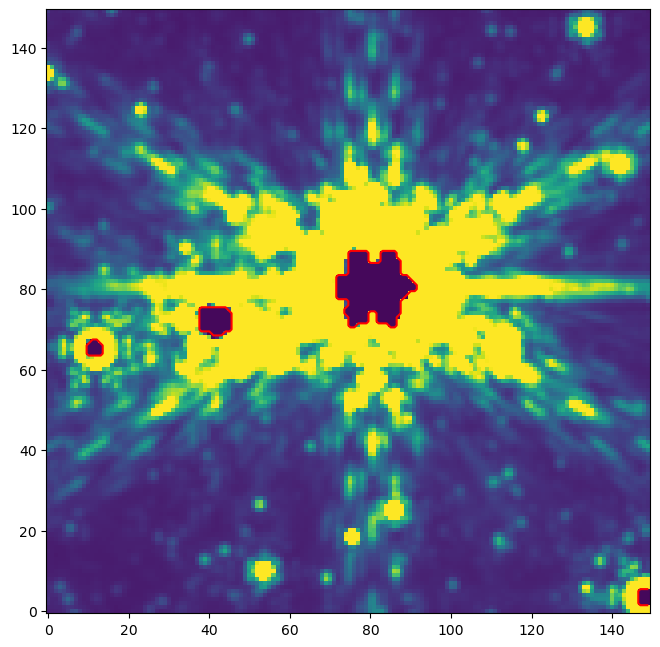

In [34]:
slc = slice(1100, 1250), slice(2050, 2200)
pl.imshow(data[slc], vmin=-1, vmax=50, origin='lower')
pl.contour(data[slc]==0, levels=[0.5], colors='r')
(data[slc]==0).sum()

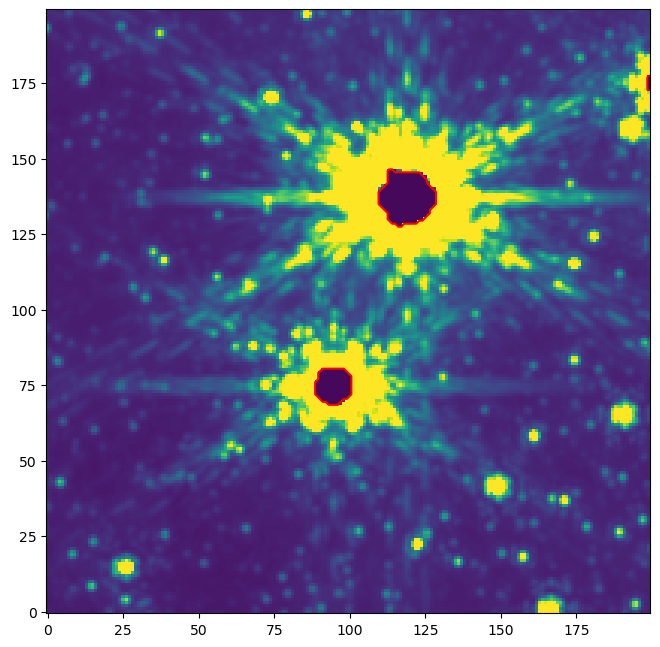

In [35]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

Reduced nsources from 3329 to 2017 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 100) and min_flux=500, number of is_star=1915, sizes=1942, centerofmass_finite=2017, coms_inbounds=2017, total=1915 candidates


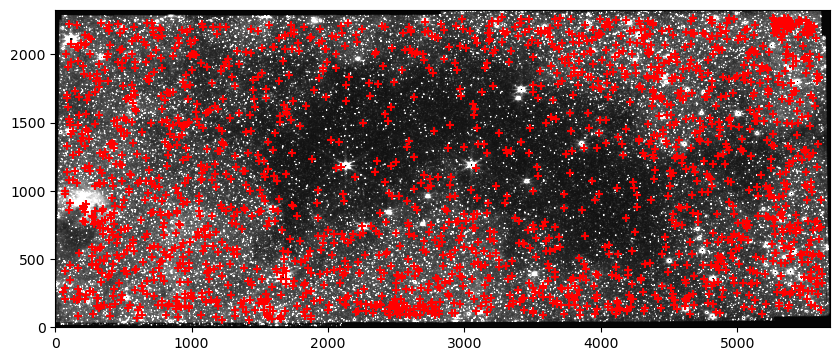

In [36]:
satstar_cat = finder_maker(min_sep_from_edge=50)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [37]:
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), fh[0].header)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
INFO: Loading grid from psf_fn=./nircam_F410M_samp2_nspsf16_npix512_nrca5.fits [__main__]
Reduced nsources from 3329 to 2017 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (100, 500) and min_flux=1000, number of is_star=74, siz

       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit     
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ------------------
       1642.546875         87.0859375 137136.67040323283   1        1 1646.4986137422343  87.46302251286356  644032.1290884716
 797.3238095238095               87.6  112735.7571088993   2        2   797.740915626537  87.56054540473356  659276.1377582601
3033.3360655737706  96.49180327868852   93669.5690223305   3        3 3033.4014720526347  96.37255334598292  680506.0049017417
 607.7787610619469  98.31858407079646 120666.29333043357   4        4  607.8123867956185  98.22522999584888  816509.2454052547
 4778.481481481482 106.76851851851852  64739.76694708811   5        5  4778.684848831525 106.66901677131705  491278.6774508923
 3115.632530120482 109.51204819277109 148471.43831024607   6        6 3116.4373116081715 109.72489505977896 160

       x_0                y_0               flux_0        id group_id       x_fit              y_fit             flux_fit           flux_unc            x_0_unc              y_0_unc       
------------------ ------------------ ------------------ --- -------- ------------------ ------------------ ------------------ ------------------ -------------------- --------------------
1652.4038461538462  57.26923076923077 114438.33788601981   1        1 1652.4167166945065 55.733640841210615  544071.2810759875 12975.669153737523  0.03626933337046725  0.03750448746920098
          1876.225            60.9375  93584.72010987438   2        2  1876.412272071561  61.31732792045048 514659.52481253596  12334.02638647931  0.03604013338844125 0.037224162760444775
1558.0597014925372  75.68656716417911   115718.626268053   3        3 1557.5702551272004   75.7532949319624 441706.49827199674 11160.891665597024 0.037720154079663885 0.041107294619468576
 1828.142857142857  81.60714285714286 106052.77595201919   4

KeyboardInterrupt: 

In [ ]:
satstar_table[:3]

In [ ]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')

In [ ]:
pl.imshow(satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

In [ ]:
pl.imshow(data[1600:1800, 3300:3500] - satstar_resid[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_fit']-3300, satstar_table['y_fit']-1600, marker='x', color='r')
pl.axis((0,200,0,200))

# Validate the starfinder (since it isn't working above...)

It is working well _now_, but this was to make the debug cycle faster by using smaller image cutouts

In [ ]:
#2510:2660,3105:3280
validation_slice = slice(1500,1950),slice(3200, 3650)

In [ ]:
pl.imshow(data[validation_slice], origin='lower')
pl.contour(data[validation_slice]==0, levels=[0.5], colors='r')

In [ ]:
saturated = data[validation_slice]==0
sources, nsources = label(saturated)
slices = find_objects(sources)

coms = center_of_mass(saturated, sources, np.arange(nsources)+1)
coms = np.array(coms)

sizes = sum_labels(saturated, sources, np.arange(nsources)+1)
msfe = 20
#sizes_ok = (sizes < max_size) & (sizes > min_size)
coms_finite = np.isfinite(coms).all(axis=1)
coms_inbounds = (
    (coms[:,1] > msfe) & (coms[:,0] > msfe) &
    (coms[:,1] < data.shape[1]-msfe) &
    (coms[:,0] < data.shape[0]-msfe)
        )
srcid=0
rindsize=3
slc = slices[0]
slc = tuple(slice(max(ss.start-rindsize, 0),
                      min(ss.stop+rindsize, shp)) for ss,shp in zip(slc, data.shape))

pl.imshow(data[validation_slice][slc])
is_star(data[validation_slice], sources, srcid+1, slices[0], min_flux=5000, rindsize=rindsize), slices, coms , sizes, nsources

In [ ]:
finder_maker(min_size=0, max_size=200)(data[validation_slice])

In [ ]:
finder_maker(min_size=0, max_size=500)(data[validation_slice], mask=ndimage.binary_dilation(data==0, iterations=1))

In [ ]:
hdr = fh[0].header.copy()
hdr.update(wcs.WCS(fh[0].header)[validation_slice].to_header())
ex_satstar_table, ex_satstar_resid = iteratively_remove_saturated_stars(data[validation_slice].copy(), hdr, verbose=True)

In [ ]:
pl.subplot(1,3,1)
pl.imshow(data[validation_slice], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
axs = (100,300,100,300)
pl.title("Data")
pl.axis(axs)

pl.subplot(1,3,2)
pl.imshow(ex_satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
pl.title("Residual")
pl.axis(axs)

pl.subplot(1,3,3)
pl.imshow(data[validation_slice] - ex_satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(ex_satstar_table['x_0'], ex_satstar_table['y_0'], marker='+', color='y')
pl.scatter(ex_satstar_table['x_fit'], ex_satstar_table['y_fit'], marker='x', color='r')
pl.title("Model")
pl.axis(axs)

# Test on F405N

In [43]:
import saturated_star_finding
import imp
imp.reload(saturated_star_finding)
from saturated_star_finding import *

In [44]:
fh = fits.open('../F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')

In [45]:
bad = (fh['CON'].data == 0) | (fh['WHT'].data == 0) | (fh['ERR'].data == 0)

In [46]:
np.any(bad)

True

In [47]:
data = fh['SCI'].data
#data[bad] = 0

Reduced nsources from 279 to 105 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (0, 1000) and min_flux=500, number of is_star=97, sizes=104, centerofmass_finite=105, coms_inbounds=97, total=97 candidates


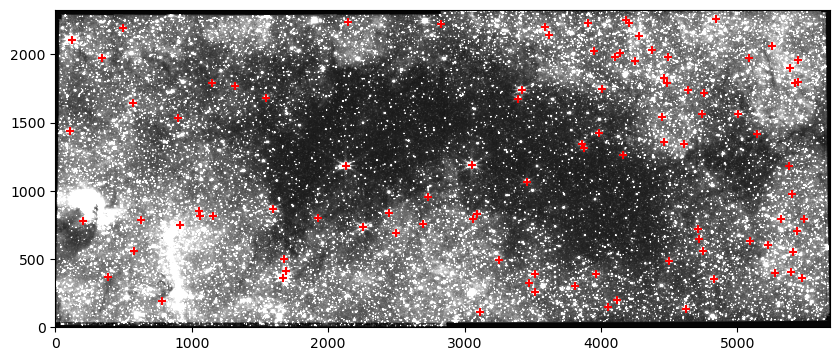

In [49]:
satstar_cat = finder_maker(min_sep_from_edge=50, max_size=1000, rindsize=4)(data)
pl.imshow(data, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_cat['xcentroid'], satstar_cat['ycentroid'], marker='+', color='r')

In [50]:
finder_maker(min_sep_from_edge=50, max_size=1000, min_size=25, rindsize=4)(data[1600:1800, 3300:3500])

Reduced nsources from 2 to 2 by excluding edge zone with size 50
inside saturated_finder, with minmax nsaturated = (25, 1000) and min_flux=500, number of is_star=1, sizes=1, centerofmass_finite=2, coms_inbounds=2, total=1 candidates


<Table length=1>
  id  xcentroid ycentroid
int64  float64   float64 
----- --------- ---------
    1    119.04     137.4

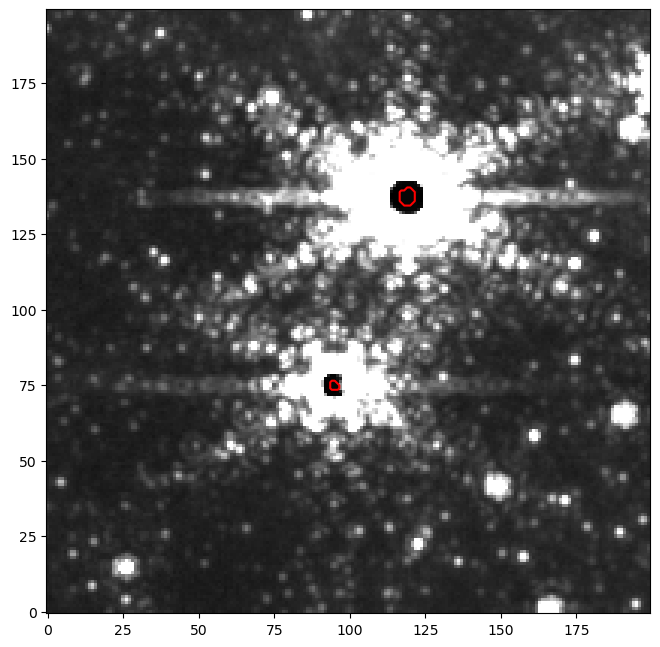

In [51]:
pl.imshow(data[1600:1800, 3300:3500], vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.contour(data[1600:1800, 3300:3500]==0, levels=[0.5], colors='r')

In [52]:
satstar_table, satstar_resid = iteratively_remove_saturated_stars(data.copy(), fh[0].header)

ReadTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Read timed out. (read timeout=None)

In [ ]:
pl.imshow(satstar_resid, vmin=-1, vmax=50, origin='lower', cmap='gray')
pl.scatter(satstar_table['x_0'], satstar_table['y_0'], marker='+', color='y')
pl.scatter(satstar_table['x_fit'], satstar_table['y_fit'], marker='x', color='r')